In [1]:
#!unzip -u "/content/drive/MyDrive/bone fracture/brone fracture train test val.zip" -d "/content/drive/MyDrive/bone fracture/dataset"
print('\n\ndone!')



done!


In [2]:
!nvidia-smi

Thu May 23 16:16:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:

from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMAGE_SIZE = [224,224]
CLASS=2
inception = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False
x = Flatten()(inception.output)
prediction = Dense(CLASS, activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)
adam = keras.optimizers.Adam(lr = 0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer = adam,
  metrics=['accuracy']
)
print("\n\n")
model.summary()

58889256/58889256 [==============================] - 4s 0us/step





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory("/content/drive/MyDrive/brone fracture train test val/train",
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
val_set = val_datagen.flow_from_directory("/content/drive/MyDrive/brone fracture train test val/val",
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory("/content/drive/MyDrive/brone fracture train test val/test",
                                            target_size = (224,224),
                                            batch_size = 1,
                                            class_mode = 'categorical')
print("\n\n")
model.optimizer.get_config()

Found 2838 images belonging to 2 classes.
Found 946 images belonging to 2 classes.
Found 1871 images belonging to 2 classes.





{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.001,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [6]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Define the paths where you want to save the files
overall_csv_filepath = "/content/drive/MyDrive/Model details/vgg16.csv"
overall_h5_filepath = "/content/drive/MyDrive/Model details/vgg16.h5"

# Ensure directory existence
os.makedirs(os.path.dirname(overall_csv_filepath), exist_ok=True)
os.makedirs(os.path.dirname(overall_h5_filepath), exist_ok=True)

# Define callbacks
checkpoint1 = ModelCheckpoint(overall_h5_filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(overall_h5_filepath, monitor='accuracy', verbose=1,
                             save_best_only=True, mode='max')
csv_logger = CSVLogger(overall_csv_filepath)

callbacks_list = [checkpoint1, checkpoint2, csv_logger]

# Training
r = model.fit_generator(
    training_set,
    epochs=30,
    validation_data=val_set,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set),
    callbacks=callbacks_list
)

# Save model weights
model.save_weights(overall_h5_filepath)


<ipython-input-6-9022576e0473>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/30
89/89 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.6913 
Epoch 1: val_accuracy improved from -inf to 0.83932, saving model to /content/drive/MyDrive/Model details/vgg16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: accuracy improved from -inf to 0.69133, saving model to /content/drive/MyDrive/Model details/vgg16.h5
89/89 [==============================] - 1698s 19s/step - loss: 0.6677 - accuracy: 0.6913 - val_loss: 0.3813 - val_accuracy: 0.8393
Epoch 2/30
89/89 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8548
Epoch 2: val_accuracy did not improve from 0.83932

Epoch 2: accuracy improved from 0.69133 to 0.85483, saving model to /content/drive/MyDrive/Model details/vgg16.h5
89/89 [==============================] - 54s 610ms/step - loss: 0.3541 - accuracy: 0.8548 - val_loss: 0.3782 - val_accuracy: 0.8140
Epoch 3/30
89/89 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8760
Epoch 3: val_accuracy improved from 0.83932 to 0.90063, saving model to /content/drive/MyDrive/Model details/vgg16.h5

Epoch 3: accuracy improved from 0.85483 to 0.87597, saving model to /content/drive/MyDrive/Model details/vgg16.h5
89/89 [==============================

In [10]:
# Assuming you have already trained your model and have loaded the test set

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_set)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


1871/1871 [==============================] - 1042s 557ms/step - loss: 0.0507 - accuracy: 0.9840
Test Accuracy: 0.9839658141136169


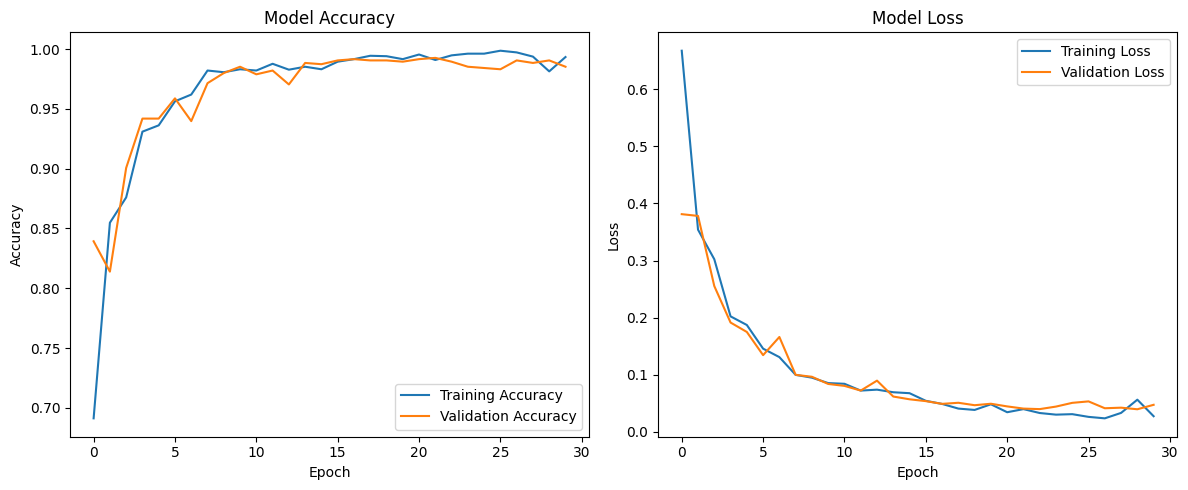

In [15]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have the training history stored in variable `r`

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training & validation accuracy values
axs[0].plot(r.history['accuracy'], label='Training Accuracy')
axs[0].plot(r.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot training & validation loss values
axs[1].plot(r.history['loss'], label='Training Loss')
axs[1].plot(r.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


1871/1871 [==============================] - 18s 10ms/step


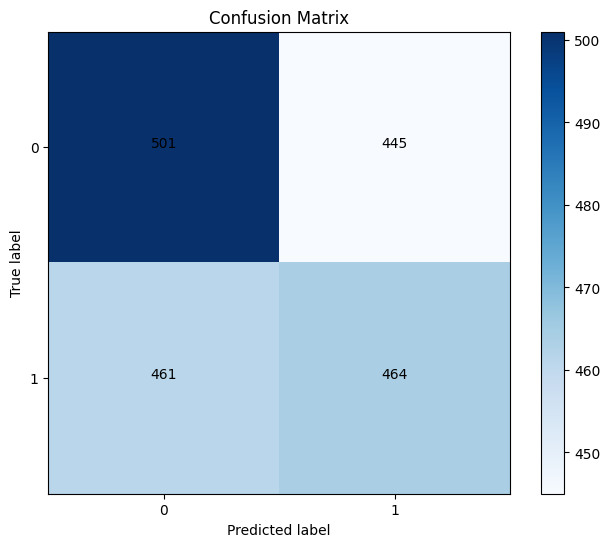

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have the test set stored in variable `test_set`

# Make predictions on the test set
predictions = model.predict(test_set)
y_true = test_set.classes
y_pred = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers to the cells
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="black" if conf_matrix[i, j] > conf_matrix.max() / 2 else "white")

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(CLASS))
plt.yticks(range(CLASS))
plt.colorbar()
plt.show()


1871/1871 [==============================] - 18s 10ms/step


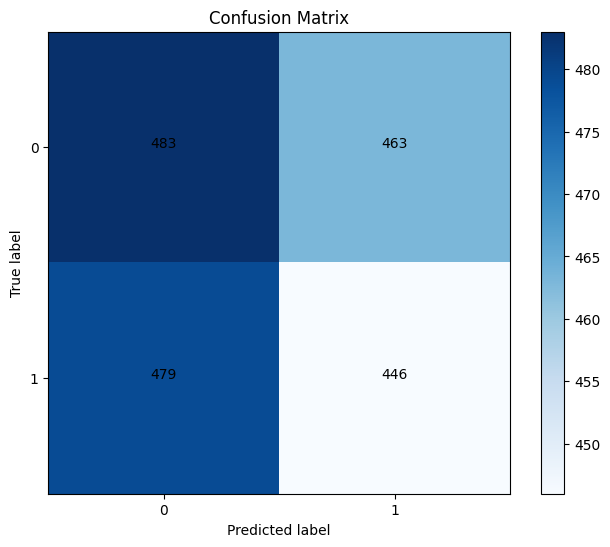

ROC AUC: 0.4963664933432375


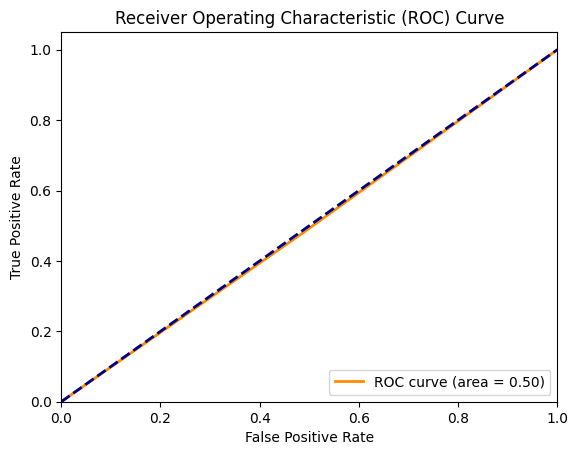

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have the test set stored in variable `test_set`

# Make predictions on the test set
predictions = model.predict(test_set)
y_true = test_set.classes
y_pred = predictions.argmax(axis=-1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers to the cells
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="black" if conf_matrix[i, j] > conf_matrix.max() / 2 else "white")

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(CLASS))
plt.yticks(range(CLASS))
plt.colorbar()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [43]:
from sklearn.metrics import classification_report

# Make predictions on the test set
predictions = model.predict(test_set)
y_true = test_set.classes
y_pred = np.argmax(predictions, axis=1)

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=test_set.class_indices.keys())

# Print the classification report
print(report)


1871/1871 [==============================] - 18s 10ms/step
              precision    recall  f1-score   support

    fracture       0.50      0.51      0.50       946
non fracture       0.49      0.48      0.48       925

    accuracy                           0.49      1871
   macro avg       0.49      0.49      0.49      1871
weighted avg       0.49      0.49      0.49      1871

